# An introduction to `relatio` 
**Runtime $\sim$ 20min**

Original paper: ["Text Semantics Capture Political and Economic Narratives"](https://arxiv.org/abs/2108.01720)

----------------------------

This is a short demo of the package `relatio`.  It takes as input a text corpus and outputs a list of narrative statements. The pipeline is unsupervised: the user does not need to specify narratives beforehand. Narrative statements are defined as tuples of semantic roles with a (agent, verb, patient) structure. 

Here, we present the main functions to quickly obtain narrative statements from a corpus.

----------------------------

In this tutorial, we work with the Trump Tweet Archive corpus.

----------------------------

In [1]:
# Catch warnings for an easy ride
from relatio import FileLogger
logger = FileLogger(level = 'WARNING')

/home/germain/Desktop/relatio/.tox/dev/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-28 15:54:50.598968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:54:51.514641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 15:54:51.514702: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

In [2]:
from relatio import load_data
df = load_data(dataset = "trump_tweet_archive", content = "raw")

In [3]:
from relatio import Preprocessor

p = Preprocessor(
    spacy_model = "en_core_web_sm",
    remove_punctuation = True,
    remove_digits = True,
    lowercase = True,
    lemmatize = True,
    remove_chars = ["\"",'-',"^",".","?","!",";","(",")",",",":","\'","+","&","|","/","{","}",
                    "~","_","`","[","]",">","<","=","*","%","$","@","#","’"],
    stop_words = [],
    n_process = -1,
    batch_size = 100
)

df = p.split_into_sentences(
    df, output_path = None, progress_bar = True
)

Splitting into sentences...


100%|██████████| 32323/32323 [01:19<00:00, 404.50it/s] 


In [4]:
from relatio import SRL

SRL = SRL(
    path = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz",
    batch_size = 10,
    cuda_device = -1
)

srl_res = SRL(df['sentence'][0:100], progress_bar=True)

from relatio import extract_roles

roles, sentence_index = extract_roles(
    srl_res, 
    used_roles = ["ARG0","B-V","B-ARGM-NEG","B-ARGM-MOD","ARG1","ARG2"],
    only_triplets = True,
    progress_bar = True
)

for d in roles[0:20]: print(d)

Running SRL...


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Extracting semantic roles...


100%|██████████| 100/100 [00:00<00:00, 17476.27it/s]

{'ARG0': 'Republicans and Democrats', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'thousands of hardworking American Patriots who', 'B-V': 'love', 'ARG1': 'our Country'}
{'ARG0': 'thousands of hardworking American Patriots who', 'B-V': 'cherish', 'ARG1': 'our values'}
{'ARG0': 'who', 'B-V': 'put', 'ARG1': 'AMERICA FIRST'}
{'ARG0': 'the Democrats', 'B-V': 'know', 'ARG1': 'it'}
{'ARG0': 'Almost all recent elections', 'B-V': 'using', 'ARG1': 'this system'}
{'ARG0': 'I', 'B-V': 'm', 'ARG1': 'running as a proud Democrat , for the Senate'}
{'ARG0': 'I', 'B-V': 'running', 'ARG1': 'for the Senate'}
{'ARG0': 'our County - China', 'B-V': 'own', 'B-ARGM-MOD': 'will', 'ARG1': 'us'}
{'ARG0': 'Sudan', 'B-V': 'agreed', 'ARG1': 'to a peace and normalization agreement with Israel'}
{'ARG0': 'that', 'B-V': 's', 'ARG1': 'to have done so in only a matter of weeks', 'ARG2': 'THREE Arabcountries'}
{'ARG0': 'Arabcountries', 'B-V': 'done', 'ARG1': 'so'}
{'ARG0': 'AdamLaxalt', 'B-V': 'finding',

In [5]:
sentence_index, roles = p.extract_svos(df['sentence'], expand_nouns = True, only_triplets = True, progress_bar = True) 
for svo in roles[0:20]: print(svo)

Extracting SVOs...


100%|██████████| 63723/63723 [00:57<00:00, 1113.40it/s]


{'ARG0': 'Republicans', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'Democrats', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'American Patriots', 'B-V': 'love', 'ARG1': 'our Country'}
{'ARG0': 'the Democrats', 'B-V': 'know', 'ARG1': 'it'}
{'ARG0': 'our County - China', 'B-V': 'own', 'ARG1': 'us'}
{'ARG0': 'that', 'B-V': 's', 'ARG1': 'THREE Arabcountries'}
{'ARG0': 'AdamLaxalt', 'B-V': 'finding', 'ARG1': 'things'}
{'ARG0': 'Pennsylvania', 'B-V': 'prevented', 'ARG1': 'us'}
{'ARG0': 'you', 'B-V': 'certify', 'ARG1': 'an election'}
{'ARG0': 'You', 'B-V': 'see', 'ARG1': 'the real numbers'}
{'ARG0': 'SenTomCotton Republicans', 'B-V': 'have', 'ARG1': 'pluses'}
{'ARG0': 'SenTomCotton Republicans', 'B-V': 'have', 'ARG1': 'amp'}
{'ARG0': 'SenTomCotton Republicans', 'B-V': 'have', 'ARG1': 'minuses'}
{'ARG0': 'We', 'B-V': 'seen', 'ARG1': 'unprecedented amounts'}
{'ARG0': 'Biden', 'B-V': 'lied', 'ARG1': 'Pennsylvania'}
{'ARG0': 'I', 'B-V': 'WON', 'ARG1': 'THE ELECTION

In [6]:
postproc_roles = p.process_roles(roles, 
                                 max_length = 50,
                                 progress_bar = True,
                                 output_path = './output/postproc_roles.json')

Cleaning phrases for role ARG0...


100%|██████████| 25587/25587 [00:09<00:00, 2684.03it/s]


Cleaning phrases for role B-V...


100%|██████████| 25587/25587 [00:08<00:00, 2927.36it/s]


Cleaning phrases for role B-ARGM-MOD...


0it [00:00, ?it/s]


Cleaning phrases for role ARG1...


100%|██████████| 25587/25587 [00:09<00:00, 2809.28it/s]


Cleaning phrases for role ARG2...


0it [00:00, ?it/s]


In [7]:
for d in postproc_roles[0:20]: print(d)

{'ARG0': 'republican', 'B-V': 'create', 'ARG1': 'our economic problem'}
{'ARG0': 'democrat', 'B-V': 'create', 'ARG1': 'our economic problem'}
{'ARG0': 'american patriot', 'B-V': 'love', 'ARG1': 'our country'}
{'ARG0': 'the democrats', 'B-V': 'know', 'ARG1': 'it'}
{'ARG0': 'our county china', 'B-V': 'own', 'ARG1': 'we'}
{'ARG0': 'that', 'B-V': 's', 'ARG1': 'three arabcountrie'}
{'ARG0': 'adamlaxalt', 'B-V': 'find', 'ARG1': 'thing'}
{'ARG0': 'pennsylvania', 'B-V': 'prevent', 'ARG1': 'we'}
{'ARG0': 'you', 'B-V': 'certify', 'ARG1': 'an election'}
{'ARG0': 'you', 'B-V': 'see', 'ARG1': 'the real number'}
{'ARG0': 'sentomcotton republicans', 'B-V': 'have', 'ARG1': 'plus'}
{'ARG0': 'sentomcotton republicans', 'B-V': 'have', 'ARG1': 'amp'}
{'ARG0': 'sentomcotton republicans', 'B-V': 'have', 'ARG1': 'minus'}
{'ARG0': 'we', 'B-V': 'see', 'ARG1': 'unprecedented amount'}
{'ARG0': 'biden', 'B-V': 'lie', 'ARG1': 'pennsylvania'}
{'ARG0': 'i', 'B-V': 'won', 'ARG1': 'the election'}
{'ARG0': 'dominion', 

In [8]:
from relatio.utils import load_roles
postproc_roles = load_roles('./output/postproc_roles.json')

In [9]:
known_entities = p.mine_entities(
    df['sentence'], 
    clean_entities = True, 
    progress_bar = True,
    output_path = './output/entities.pkl'
)

for n in known_entities.most_common(10): print(n)

Mining named entities...


100%|██████████| 63723/63723 [01:07<00:00, 947.92it/s] 

('democrats', 1151)
('china', 902)
('u s', 841)
('american', 577)
('america', 573)
('trump', 516)
('barackobama', 497)
('republicans', 437)
('the united states', 421)
('republican', 415)


In [10]:
from relatio.utils import load_entities
known_entities = load_entities('./output/entities.pkl')

top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

In [11]:
import tensorflow as tf
tf.config.experimental.enable_tensor_float_32_execution(False)

In [12]:
from relatio.narrative_models import NarrativeModel

m = NarrativeModel(
    clustering = 'kmeans',
    PCA = True,
    UMAP = True,
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1'],
    roles_with_known_entities = ['ARG0','ARG1'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'character_matching',
    roles_with_unknown_entities = ['ARG0','ARG1'],
    threshold = 0.3
)    
             
m.fit(postproc_roles, progress_bar = True) 

2023-03-28 15:59:16.473395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-28 15:59:16.473442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (germain-XPS-15-9500): /proc/driver/nvidia/version does not exist
2023-03-28 15:59:16.474709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Matching known entities (with character matching)...


100%|██████████| 5728/5728 [00:00<00:00, 13717.68it/s]


Matching known entities (with character matching)...


100%|██████████| 9948/9948 [00:00<00:00, 13012.85it/s]


Computing phrase embeddings...


100%|██████████| 12792/12792 [00:48<00:00, 264.41it/s]


Dimension reduction via PCA...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
Dimension reduction via UMAP...
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}
Clustering phrases into clusters...
Clustering parameters chosen in this range:
{'n_clusters': [12, 31, 63, 94, 127], 'random_state': 0}
The silhouette score suggests the optimal number of clusters is 12. This corresponds to index 0.
The elbow method (inertia score) suggests the optimal number of clusters is 31. This corresponds to index 1.
Labeling the clusters by the most frequent phrases...


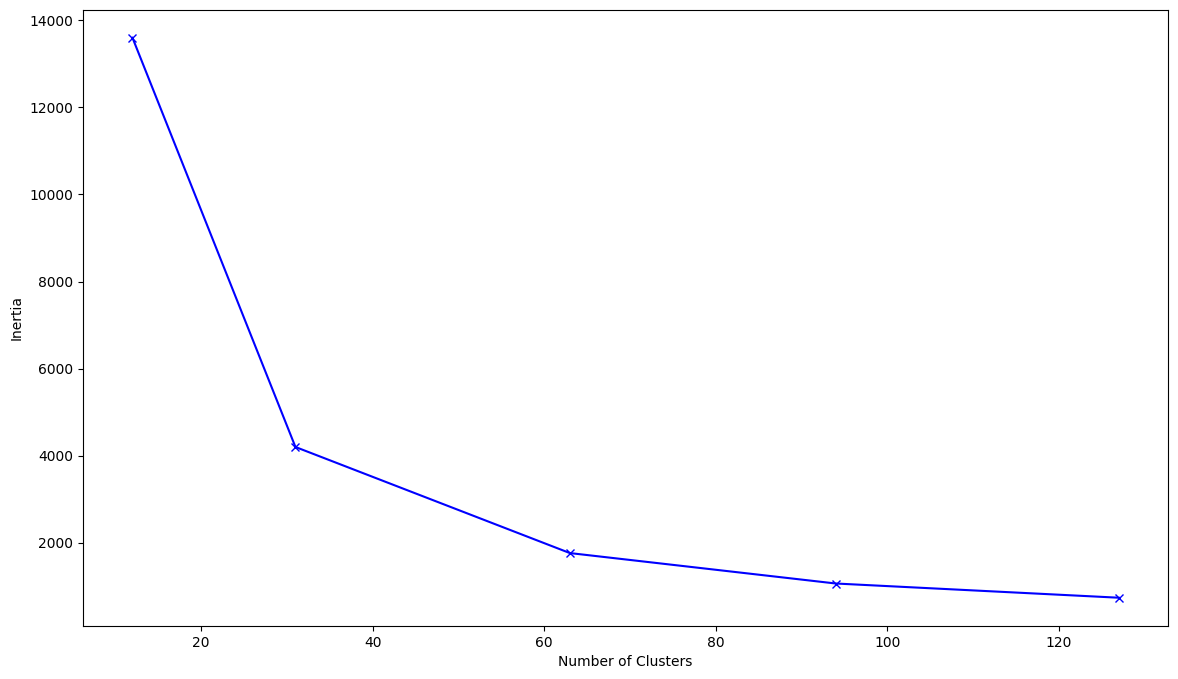

In [13]:
m.plot_selection_metric(metric = 'inertia') 

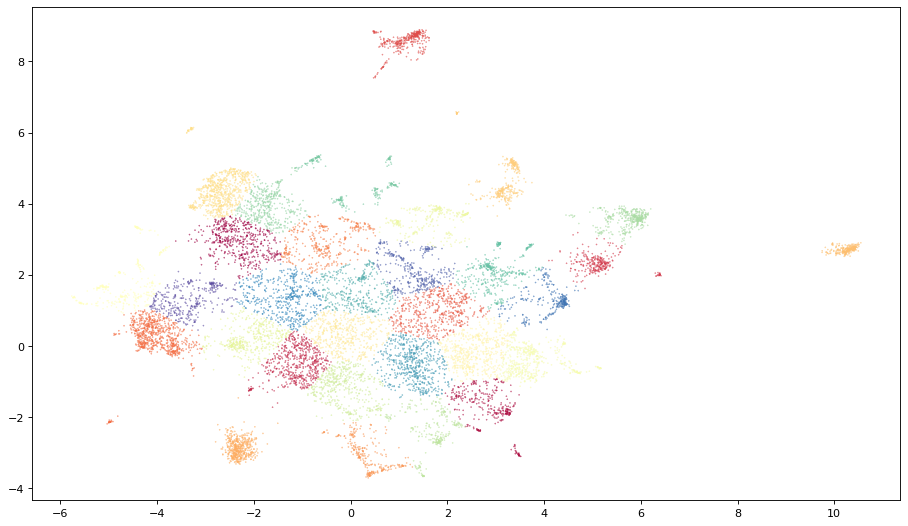

In [14]:
m.plot_clusters(path = './output/clusters.pdf') 

In [15]:
m.clusters_to_txt(path = './output/clusters.txt')

In [16]:
narratives = m.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|██████████| 25545/25545 [00:02<00:00, 11783.14it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|██████████| 21165/21165 [01:08<00:00, 309.74it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|██████████| 25434/25434 [00:01<00:00, 14529.81it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|██████████| 23154/23154 [01:11<00:00, 322.87it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...


In [17]:
from relatio.utils import prettify

pretty_narratives = []
for n in narratives: 
    pretty_narratives.append(prettify(n))

for i in range(10):           
    print(roles[i])
    print(postproc_roles[i])
    print(pretty_narratives[i])

{'ARG0': 'Republicans', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'republican', 'B-V': 'create', 'ARG1': 'our economic problem'}
republican create we
{'ARG0': 'Democrats', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'democrat', 'B-V': 'create', 'ARG1': 'our economic problem'}
democrat create we
{'ARG0': 'American Patriots', 'B-V': 'love', 'ARG1': 'our Country'}
{'ARG0': 'american patriot', 'B-V': 'love', 'ARG1': 'our country'}
american love we
{'ARG0': 'the Democrats', 'B-V': 'know', 'ARG1': 'it'}
{'ARG0': 'the democrats', 'B-V': 'know', 'ARG1': 'it'}
democrats know they
{'ARG0': 'our County - China', 'B-V': 'own', 'ARG1': 'us'}
{'ARG0': 'our county china', 'B-V': 'own', 'ARG1': 'we'}
china own we
{'ARG0': 'that', 'B-V': 's', 'ARG1': 'THREE Arabcountries'}
{'ARG0': 'that', 'B-V': 's', 'ARG1': 'three arabcountrie'}
they s i
{'ARG0': 'AdamLaxalt', 'B-V': 'finding', 'ARG1': 'things'}
{'ARG0': 'adamlaxalt', 'B-V': 'find', 'ARG1': 'thing'}
foxnew find what


In [18]:
from relatio import build_graph, draw_graph

G = build_graph(
    narratives, 
    top_n = 100, 
    prune_network = True
)

draw_graph(
    G,
    notebook = True,
    show_buttons = False,
    width="1600px",
    height="1000px",
    output_filename = './output/network_of_narratives.html'
    )

./output/network_of_narratives.html
